# Steiner trees

## What are Steiner Trees?

Steiner trees are a fundamental concept in network optimization. Given a graph with weighted edges and a subset of vertices called terminals, a Steiner tree is the minimum-cost tree that connects all the terminal nodes. Unlike a minimum spanning tree which must include all vertices in the graph, a Steiner tree may include additional non-terminal vertices (called Steiner points) to minimize the overall cost.

Steiner tree problems are widely used for the analysis of biological networks, such as protein-protein interaction networks.

## How CORNETO Solves Steiner Tree Problems

CORNETO provides powerful capabilities for exactly solving Steiner tree problems through its `SteinerTreeFlow` method. Unlike approximation algorithms, CORNETO offers exact solutions using mathematical programming formulations.

### Key Features:

1. **Graph Flexibility**: CORNETO supports various graph types:
   - **Undirected graphs**: Find the optimal tree connecting terminals with bidirectional edges
   - **Directed graphs**: Connect terminals respecting edge directions, with optimal root selection
   - **Mixed graphs**: Combine directed and undirected edges in the same problem

2. **Root Selection Strategies**:
   - Automatically find the optimal root node
   - Specify a particular node as the root

3. **Customization Options**:
   - Edge costs can be specified individually
   - Regularization to control tree complexity
   - Strict acyclic constraint enforcement
   - Optimize multiple samples simultaneously with structured sparsity regularization

4. **Solver Flexibility**: Compatible with many MILP mathematical programming solvers (SCIP, HIGHS, GUROBI, etc.)

This notebook demonstrates how to use CORNETO to solve Steiner tree problems on both undirected and directed graphs, comparing the results with NetworkX's approximation algorithms.


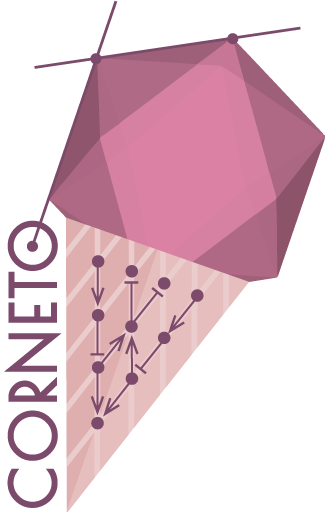

In [1]:
import corneto as cn
import networkx as nx
import numpy as np
import random
from networkx.algorithms.approximation import steiner_tree

cn.info()

In [2]:
def generate_random_graph(num_nodes=100, probability=0.1, num_terminals=10, seed=0):
    """
    Generates a random weighted graph using the Erdős-Rényi model
    and randomly selects terminal nodes.
    
    Returns:
        G: The generated graph with weighted edges.
        terminals: A list of terminal nodes.
    """
    random.seed(seed)
    G = nx.erdos_renyi_graph(num_nodes, probability)
    # Assign random weights to each edge
    for u, v in G.edges():
        G[u][v]['value'] = random.uniform(1, 10)
    
    # Select terminal nodes ensuring not to exceed the available nodes
    terminals = random.sample(list(G.nodes()), min(num_terminals, G.number_of_nodes()))
    # Set node attribute "terminal"
    for node in G.nodes():
        G.nodes[node]['terminal'] = node in terminals
    return G, terminals


def calculate_cost(G, T):
    total_cost = sum(d['value'] for u, v, d in T.edges(data=True))
    return total_cost


def compute_steiner_tree_cost(G, terminals):
    """
    Computes the Steiner tree approximation on graph G for given terminal nodes
    and returns the tree along with its total cost (sum of edge weights).
    
    Parameters:
        G: A weighted networkx graph.
        terminals: A list of terminal nodes for the Steiner tree.
        
    Returns:
        T: The Steiner tree as a subgraph of G.
        total_cost: Sum of the weights of the edges in T.
    """
    T = steiner_tree(G, terminals, weight='value')
    # Calculate the total cost by summing up the weights of each edge in the tree
    return T, calculate_cost(G,T)


num_nodes = 100
probability = 0.1
num_terminals = 10
G, terminals = generate_random_graph(num_nodes, probability, num_terminals)

print(f"Terminal nodes: {terminals}")

# Compute the Steiner tree and its cost
T, cost = compute_steiner_tree_cost(G, terminals)

print(f"Computed Steiner tree has {T.number_of_nodes()} nodes and {T.number_of_edges()} edges.")
print(f"Total cost of the Steiner tree: {cost:.4f}")


Terminal nodes: [58, 14, 68, 62, 95, 41, 23, 39, 64, 13]
Computed Steiner tree has 19 nodes and 18 edges.
Total cost of the Steiner tree: 46.7653


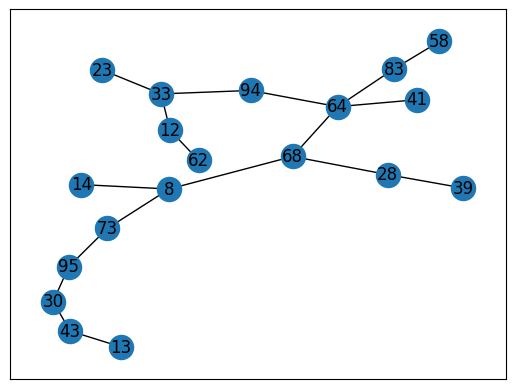

In [3]:
nx.draw_networkx(T)

In [4]:
T.edges()

EdgeView([(64, 41), (64, 68), (64, 83), (64, 94), (68, 8), (68, 28), (8, 14), (8, 73), (73, 95), (12, 33), (12, 62), (13, 43), (83, 58), (23, 33), (28, 39), (30, 43), (30, 95), (94, 33)])

## Importing data to CORNETO

CORNETO offers a simple way to import networkx graphs as CORNETO graphs. We will convert first the networkx G, and then we will extract the values to create a `Data` object to use the CORNETO Steiner Tree method. Note that, even though CORNETO supports graph attributes, we typically distinguish between prior knowledge data (this is embedded in the graphs as attributes) and our experimental data (e.g., deregulated proteins that we want to connect using information in G).

In [5]:
from corneto.contrib.networkx import networkx_to_corneto_graph, corneto_graph_to_networkx
Gc = networkx_to_corneto_graph(G)
Gc.shape

(100, 511)

In [6]:
from corneto._data import Data

features = []

# We create a list of features, where each feature contains
# id: the id of the edge.
# mapping: if the feature maps to edges/nodes of the graph,
#          in this case, each feature is the cost of the edge
for i, attr in enumerate(Gc.get_attr_edges()):
    features.append(dict(id=i, mapping="edge", value=attr.value))

# We also add information about which of the vertices from the
# graph are the terminals to connect with a steiner tree
for v in Gc.V:
    attr = Gc.get_attr_vertex(v)
    if attr['terminal']:
        features.append(dict(id=v, mapping="vertex", role="terminal"))

features[:5]

[{'id': 0, 'mapping': 'edge', 'value': 6.846636018985803},
 {'id': 1, 'mapping': 'edge', 'value': 3.6607884661297745},
 {'id': 2, 'mapping': 'edge', 'value': 4.92734092175005},
 {'id': 3, 'mapping': 'edge', 'value': 4.0719471869531425},
 {'id': 4, 'mapping': 'edge', 'value': 6.894624813053817}]

In [7]:
# We create the data object, we only have 1 sample (1 steiner tree to recover)
D = Data.from_dict({"s1": {"features": features}})
D

Data(n_samples=1, n_feats=[521])

## Solving the problem with the exact steiner tree

In [8]:
from corneto.methods.future.steiner import SteinerTreeFlow

# We create a SteinerTreeFlow problem. If edges do not have data, we
# assume the cost is 1 (in this case, every edge in our data object has
# a cost, so this is ignored
m = SteinerTreeFlow(lambda_reg=0, strict_acyclic=True, default_edge_cost=1)
P = m.build(Gc, D)
P.expr

{'_flow': _flow: Variable((521,), _flow),
 '_flow_ipos': _flow_ipos: Variable((521,), _flow_ipos, boolean=True),
 '_flow_ineg': _flow_ineg: Variable((521,), _flow_ineg, boolean=True),
 '_dag_layer': _dag_layer: Variable((100, 1), _dag_layer),
 'flow': _flow: Variable((521,), _flow),
 'with_flow': Expression(AFFINE, NONNEGATIVE, (521,))}

In [9]:
# For larger problems, use a solver like GUROBI.
P.solve(solver="scipy");

for o in P.objectives:
    print(o.value)

35.85180933414297
28.0


## Extracting the tree and plotting

Once solved, we can access the variable `with_flow` to see which edges were selected by the method

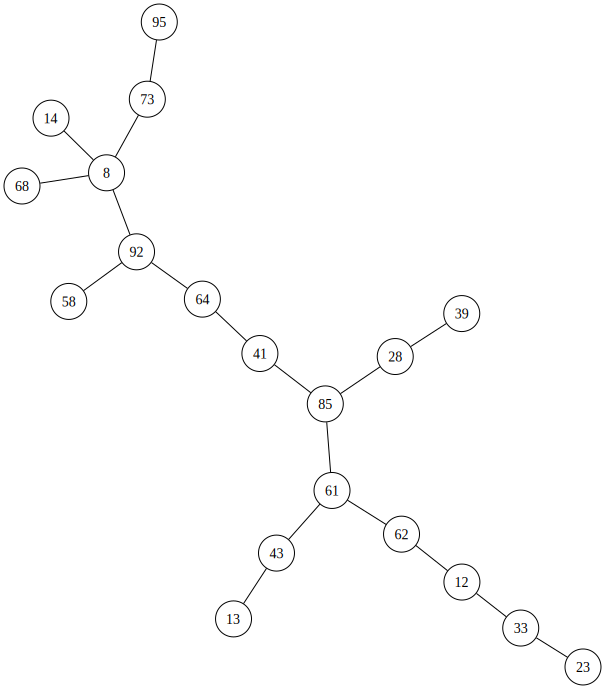

In [10]:
sol = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value>0.5))
sol.plot(orphan_edges=False, layout="neato")

In [11]:
# This is the total cost of the steiner tree
sum([attr.get("value", 0) for attr in sol.get_attr_edges()])

35.85180933414298

In [12]:
# We can check that the cost is correct using the original networkx data
sel_edges = [(list(s)[0], list(t)[0]) for s, t in sol.E if s and t]
T_corneto = G.edge_subgraph(sel_edges)
calculate_cost(G, T_corneto)

35.85180933414298

In [13]:
# We check that all terminals are contained in the solution
set(sol.V).intersection(terminals) == set(terminals)

True

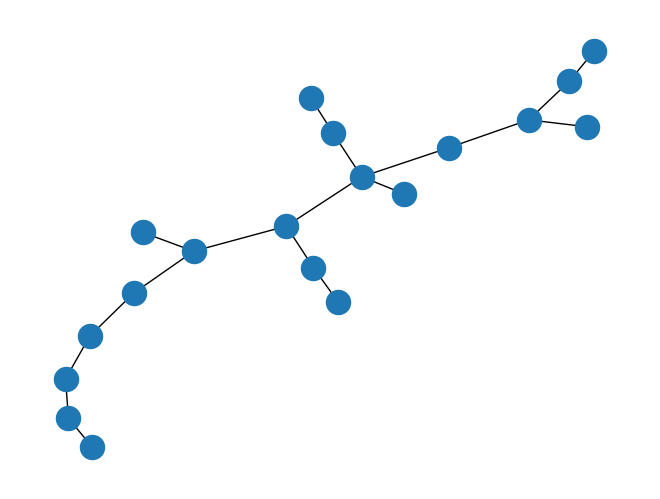

In [14]:
nx.draw(T)

## Directed graphs

CORNETO supports also directed steiner trees (and even a mixed set of directed or undirected edges). In the directed case, the selection of a root node is important, since not every vertex is reachable in a tree, depending on the directions. CORNETO can also find the best root possible, so it explores the entire space of potential trees, starting from different roots.

In [15]:
# We create a directed version of the graph
G_dir = G.to_directed()
Gc = networkx_to_corneto_graph(G_dir)

features = []
for i, attr in enumerate(Gc.get_attr_edges()):
    features.append(dict(id=i, mapping="edge", value=attr.value))
for v in Gc.V:
    attr = Gc.get_attr_vertex(v)
    if attr['terminal']:
        features.append(dict(id=v, mapping="vertex", role="terminal"))

D = Data.from_dict({"s1": {"features": features}})
D

Data(n_samples=1, n_feats=[1032])

In [16]:
# We find the best root, but we can provide one
m = SteinerTreeFlow(lambda_reg=0, strict_acyclic=True, root_selection_strategy="best")
P = m.build(Gc, D)
P.solve(solver="scipy");

for o in P.objectives:
    print(o.value)

35.85180933414297
27.999999999999993


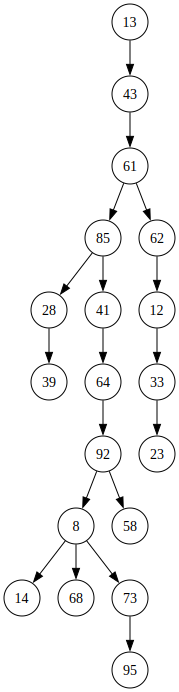

In [17]:
sol = m.processed_graph.edge_subgraph(np.flatnonzero(np.abs(P.expr.with_flow.value)>0.5))
sol.plot(orphan_edges=False)

In [18]:
set(sol.V).intersection(terminals) == set(terminals)

True

In [19]:
sum([attr.get("value", 0) for attr in sol.get_attr_edges()])

35.85180933414298

In [20]:
sel_edges = [(list(s)[0], list(t)[0]) for s, t in sol.E if s and t]
calculate_cost(G, G.edge_subgraph(sel_edges))

35.85180933414298

## Mixed graphs

Mixed graphs (graphs with directed edges, undirected edges, multiple edges) are naturally supported by CORNETO. Here we see the different steiner trees that we can obtain from a mixed graph, depending on the direction of the edges

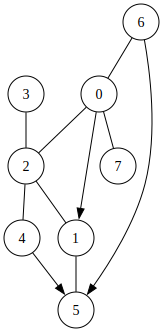

In [21]:
G_mixed = cn.Graph()
G_mixed.add_edge(0, 1, type=cn.EdgeType.DIRECTED)
G_mixed.add_edge(0, 2, type=cn.EdgeType.UNDIRECTED)
G_mixed.add_edge(2, 1, type=cn.EdgeType.UNDIRECTED)
G_mixed.add_edge(3, 2, type=cn.EdgeType.UNDIRECTED)
G_mixed.add_edge(2, 4, type=cn.EdgeType.UNDIRECTED)
G_mixed.add_edge(4, 5, type=cn.EdgeType.DIRECTED) # UNDIR
G_mixed.add_edge(6, 5, type=cn.EdgeType.DIRECTED)
G_mixed.add_edge(6, 0, type=cn.EdgeType.UNDIRECTED)
G_mixed.add_edge(1, 5, type=cn.EdgeType.UNDIRECTED)
G_mixed.add_edge(0, 7, type=cn.EdgeType.UNDIRECTED)
G_mixed.plot()

In [22]:
D = cn.Data.from_cdict(
    {
        "steiner": {
            0: {
                "mapping": "vertex",
                "role": "terminal"
            },
            5: {
                "mapping": "vertex",
                "role": "terminal"
            },
            6: {
                "mapping": "vertex",
                "role": "terminal"
            }, 
            4: {
                "mapping": "vertex",
                "role": "terminal"
            }, 
        }
    }
)

m = SteinerTreeFlow(root_selection_strategy="best")
P = m.build(G_mixed, D)

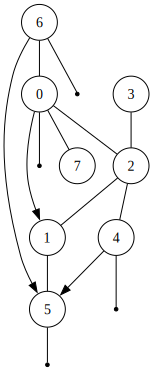

In [23]:
m.processed_graph.plot()

In [24]:
P.solve(solver="scipy");

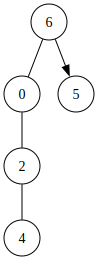

In [25]:
sol = m.processed_graph.edge_subgraph(np.flatnonzero(np.abs(P.expr.with_flow.value)>0.5))
sol.plot(orphan_edges=False)

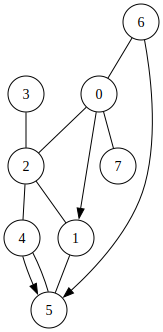

In [26]:
G_mixed.add_edge(4, 5, type=cn.EdgeType.UNDIRECTED)
G_mixed.plot()

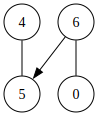

In [27]:
m = SteinerTreeFlow(root_selection_strategy="best")
P = m.build(G_mixed, D)
P.solve(solver="scipy")

sol = m.processed_graph.edge_subgraph(np.flatnonzero(np.abs(P.expr.with_flow.value)>0.5))
sol.plot(orphan_edges=False)